# Cloning Repo

In [1]:
! git clone https://github.com/cansyl/DEEPScreen.git

Cloning into 'DEEPScreen'...
remote: Enumerating objects: 5470, done.
remote: Total 5470 (delta 0), reused 0 (delta 0), pack-reused 5470
Receiving objects: 100% (5470/5470), 267.96 MiB | 27.11 MiB/s, done.
Resolving deltas: 100% (2546/2546), done.


# Dependencies

In [4]:
!pip install bioservices
## !easy_install --upgrade pip
!pip install torch-geometric torch-scatter==latest+cu101 torch-sparse==latest+cu101 --no-cache-dir -f https://s3.eu-central-1.amazonaws.com/pytorch-geometric.com/whl/torch-1.5.0.html

Looking in links: https://s3.eu-central-1.amazonaws.com/pytorch-geometric.com/whl/torch-1.5.0.html
     |████████████████████████████████| 174kB 2.9MB/s 
     |████████████████████████████████| 12.3MB 4.7MB/s 
     |████████████████████████████████| 21.6MB 3.9MB/s 
     |████████████████████████████████| 235kB 7.4MB/s 
     |████████████████████████████████| 2.1MB 8.6MB/s 
     |████████████████████████████████| 51kB 14.0MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-1.6.0-cp36-none-any.whl size=296339 sha256=6588016869b309212f1f43c1beb492be733512f97e4552e5b08cc30d16d0b263
  Stored in directory: /tmp/pip-ephem-wheel-cache-d_xpzsqz/wheels/5f/7f/33/acea5809d8580a7adf60dcd6d04f5fc50a7f983040f68be1ff
Successfully built torch-geometric


In [5]:
# for creating molecular graphs

!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit

import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2020-07-08 20:22:09--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.201.79, 104.18.200.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.201.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh [following]
--2020-07-08 20:22:09--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88867207 (85M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>]  84.75M   141MB/s    in 0.6s    

2020-07-08 20:22:09 (141 MB/s) - ‘Miniconda3-latest-Linux

# Data Preprocessing

In [6]:
### GETTING LIST OF ACTIVE INACTIVE COMPOUNDS OF CHEMBL286 ### 
def get_act_inact_list_for_a_target(target, fl):
    act_list = []
    inact_list = []

    with open("{}/{}".format(training_files_path, fl))  as f:
        for line in f:
            if line != "":
                line=line.split("\n")[0]
                chembl_part, comps = line.split("\t")
                chembl_target_id, act_inact = chembl_part.split("_")
                if chembl_target_id == target:
                    if act_inact == "act":
                        act_list = comps.split(",")
                    else:
                        inact_list = comps.split(",")
                        break

    return act_list, inact_list


training_files_path = "/content/DEEPScreen/training_files"
fl = "chembl27_preprocessed_filtered_act_inact_comps_10.0_20.0_blast_comp_0.2.txt"

protein_id = "CHEMBL286"
act,inact = get_act_inact_list_for_a_target(protein_id,fl)

print("\n\nFOR ChEMBL256")
print("TOTAL NUMBER OF INACTIVE COMPOUNDS ",len(inact))
print("TOTAL NUMBER OF ACTIVE COMPOUNDS",len(act))


[Errno 2] No such file or directory: 'DEEPScreen'
/content/DEEPScreen


FOR ChEMBL256
TOTAL NUMBER OF INACTIVE COMPOUNDS  741
TOTAL NUMBER OF ACTIVE COMPOUNDS 2797


In [61]:
### CONVERTING CHEMBL TO SMILES FOR ACTIVE INACTIVE COMPOUNDS OF CHEMBL286 ### 
from bioservices.chembl import ChEMBL
import os
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import DrawingOptions
import networkx as nx
import numpy as np
import json

c = ChEMBL()

smiles_dict = dict()
for cmpnd in inact:
    mol = c.get_molecule(cmpnd)
    smiles_dict[cmpnd] = mol["molecule_structures"]["canonical_smiles"]

for cmpnd in act:
    mol = c.get_molecule(cmpnd)
    smiles_dict[cmpnd] = mol["molecule_structures"]["canonical_smiles"]

protein_id = "CHEMBL286"
project_file_path = "{}DEEPScreen".format(os.getcwd().split("DEEPScreen")[0])
training_files_path = "{}/training_files/target_training_datasets/{}".format(project_file_path,protein_id)

# print(training_files_path)
%cd $training_files_path
with open('smiles_dict.json', 'w') as fp:
    json.dump(smiles_dict, fp)


/content/DEEPScreen/training_files/target_training_datasets/CHEMBL286


In [63]:
### PREPARING DATASET ###
import os
import sys
import cv2
import json
import torch
import random
import warnings
import subprocess
import numpy as np
import pandas as pd
from operator import itemgetter
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler, BatchSampler, SequentialSampler
"""
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import DrawingOptions
import cairosvg
"""


warnings.filterwarnings(action='ignore')

drive_path = "/content/drive/My Drive/DeepScreen" # add your drive path here

project_file_path = "{}/DEEPScreen".format(os.getcwd().split("DEEPScreen")[0])
training_files_path = "{}/training_files".format(project_file_path)
result_files_path = "{}/result_files".format(drive_path)
trained_models_path = "{}/trained_models".format(drive_path)

IMG_SIZE = 200


import pandas as pd
# import numpy as np
# import os
# import random
import json, pickle
from collections import OrderedDict
from rdkit import Chem
from rdkit.Chem import MolFromSmiles
import networkx as nx

def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        # print(x)
        raise Exception('input {0} not in allowable set{1}:'.format(x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))


def one_of_k_encoding_unk(x, allowable_set):
    '''Maps inputs not in the allowable set to the last element.'''
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))


def atom_features(atom):
    # 44 +11 +11 +11 +1
    return np.array(one_of_k_encoding_unk(atom.GetSymbol(),
                                          ['C', 'N', 'O', 'S', 'F', 'Si', 'P', 'Cl', 'Br', 'Mg', 'Na', 'Ca', 'Fe', 'As',
                                           'Al', 'I', 'B', 'V', 'K', 'Tl', 'Yb', 'Sb', 'Sn', 'Ag', 'Pd', 'Co', 'Se',
                                           'Ti', 'Zn', 'H', 'Li', 'Ge', 'Cu', 'Au', 'Ni', 'Cd', 'In', 'Mn', 'Zr', 'Cr',
                                           'Pt', 'Hg', 'Pb', 'X']) +
                    one_of_k_encoding(atom.GetDegree(), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) +
                    one_of_k_encoding_unk(atom.GetTotalNumHs(), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) +
                    one_of_k_encoding_unk(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) +
                    [atom.GetIsAromatic()])



def smile_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)

    c_size = mol.GetNumAtoms()

    features = []
    for atom in mol.GetAtoms():
        feature = atom_features(atom)
        features.append(feature / sum(feature))

    edges = []
    for bond in mol.GetBonds():
        edges.append([bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()])
    g = nx.Graph(edges).to_directed()
    edge_index = []
    mol_adj = np.zeros((c_size, c_size))
    for e1, e2 in g.edges:
        mol_adj[e1, e2] = 1
        # edge_index.append([e1, e2])
    mol_adj += np.matrix(np.eye(mol_adj.shape[0]))
    index_row, index_col = np.where(mol_adj >= 0.5)
    for i, j in zip(index_row, index_col):
        edge_index.append([i, j])
    
    return (c_size, features, edge_index)
#############################################

def create_final_randomized_training_val_test_sets(target, neg_act_inact_fl, smiles_dict,batch_size):
    
    # chemblid_smiles_dict = get_chemblid_smiles_inchi_dict(smiles_inchi_fl)
    # with open(smiles_inchi_fl) as f:
    chemblid_smiles_dict = json.load(open(smiles_dict))

    act_list, inact_list = get_act_inact_list_for_a_target(target, neg_act_inact_fl)

    if len(inact_list) >= len(act_list):
        inact_list = inact_list[:len(act_list)]
    else:
        act_list = act_list[:int(len(inact_list) * 1.5)]

    random.shuffle(act_list)
    random.shuffle(inact_list)

    act_training_validation_size = int(0.8 * len(act_list))
    act_training_size = int(0.8 * act_training_validation_size)
    act_val_size = act_training_validation_size - act_training_size
    
    training_act_comp_id_list = act_list[:act_training_size]
    val_act_comp_id_list = act_list[act_training_size:act_training_size+act_val_size]
    test_act_comp_id_list = act_list[act_training_size+act_val_size:]

    inact_training_validation_size = int(0.8 * len(inact_list))
    inact_training_size = int(0.8 * inact_training_validation_size)
    inact_val_size = inact_training_validation_size - inact_training_size
    
    training_inact_comp_id_list = inact_list[:inact_training_size]
    val_inact_comp_id_list = inact_list[inact_training_size:inact_training_size+inact_val_size]
    test_inact_comp_id_list = inact_list[inact_training_size+inact_val_size:]

    print(target, "all training act", len(act_list),len(training_act_comp_id_list), len(val_act_comp_id_list), len(test_act_comp_id_list) )
    print(target, "all training inact", len(inact_list), len(training_inact_comp_id_list), len(val_inact_comp_id_list),
          len(test_inact_comp_id_list))
    
    tar_train_val_test_dict = dict()
    
    tar_train_val_test_dict["training"] = []
    tar_train_val_test_dict["validation"] = []
    tar_train_val_test_dict["test"] = []
    training_smile_graph = dict()
    val_smile_graph = dict()
    test_smile_graph = dict()
    for comp_id in training_act_comp_id_list:
        try:
            training_smile_graph[comp_id] = smile_to_graph(chemblid_smiles_dict[comp_id])
            tar_train_val_test_dict["training"].append([comp_id, 1])
        except:
            # print("A TRAIN EXCEPT")
            pass
    for comp_id in val_act_comp_id_list:
        try:
            val_smile_graph[comp_id] = smile_to_graph(chemblid_smiles_dict[comp_id])
            tar_train_val_test_dict["validation"].append([comp_id, 1])
        except:
            
            # print("A VAL EXCEPT")
            pass

    for comp_id in test_act_comp_id_list:
        try:
            test_smile_graph[comp_id] = smile_to_graph(chemblid_smiles_dict[comp_id])
            tar_train_val_test_dict["test"].append([comp_id, 1])
        except:
            
            # print("A TEST EXCEPT")
            pass

    for comp_id in training_inact_comp_id_list:
        try:
            training_smile_graph[comp_id] = smile_to_graph(chemblid_smiles_dict[comp_id])
            tar_train_val_test_dict["training"].append([comp_id, 0])
        except:
            # print("I TRAIN EXCEPT")
            pass
    for comp_id in val_inact_comp_id_list:
        try:
            val_smile_graph[comp_id] = smile_to_graph(chemblid_smiles_dict[comp_id])
            tar_train_val_test_dict["validation"].append([comp_id, 0])
        except:
            # print("I VAL EXCEPT")
            pass
    for comp_id in test_inact_comp_id_list:
        try:
            test_smile_graph[comp_id] = smile_to_graph(chemblid_smiles_dict[comp_id])
            tar_train_val_test_dict["test"].append([comp_id, 0])
        except:
            # print("I TEST EXCEPT")
            pass
    random.shuffle(tar_train_val_test_dict["training"])
    random.shuffle(tar_train_val_test_dict["validation"])
    random.shuffle(tar_train_val_test_dict["test"])

    print(len(tar_train_val_test_dict["training"]))
    print(len(tar_train_val_test_dict["validation"]))
    print(len(tar_train_val_test_dict["test"]))
    training_dataset = DTADataset(root ='data',data = tar_train_val_test_dict["training"] ,smile_graph = training_smile_graph)
    print(len(training_dataset))
    validation_dataset = DTADataset(root ='data',data = tar_train_val_test_dict["validation"] ,smile_graph = val_smile_graph)

    test_dataset = DTADataset(root ='data',data = tar_train_val_test_dict["test"] ,smile_graph = test_smile_graph)

    train_sampler = SubsetRandomSampler(range(len(training_dataset)))
    train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size,
                                              sampler=train_sampler,collate_fn=collate)
    
    validation_sampler = SubsetRandomSampler(range(len(validation_dataset)))
    validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size,
                                              sampler=validation_sampler,collate_fn=collate)

    test_sampler = SubsetRandomSampler(range(len(test_dataset)))
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                              sampler=test_sampler,collate_fn=collate)

    return train_loader, validation_loader, test_loader


## Custom DataLoader

In [65]:
import os
from torch_geometric.data import InMemoryDataset, DataLoader, Batch
from torch_geometric import data as DATA
import torch



class DTADataset(InMemoryDataset):
    def __init__(self, root='/tmp',
                 data = None, transform=None,
                 pre_transform=None, smile_graph=None):

        super(DTADataset, self).__init__(root, transform, pre_transform)
        # self.dataset = dataset
        self.process(data, smile_graph)

    @property
    def raw_file_names(self):
        pass
        # return ['some_file_1', 'some_file_2', ...]

    @property
    def processed_file_names(self):
        pass
        # return [self.dataset + '_data_mol.pt', self.dataset + '_data_pro.pt']

    def download(self):
        # Download to `self.raw_dir`.
        pass

    def _download(self):
        pass

    def _process(self):
        if not os.path.exists(self.processed_dir):
            os.makedirs(self.processed_dir)

    def process(self, moldata, smile_graph):
        
        data_list_mol = []

        for i in range(len(moldata)):

            chemblid = moldata[i][0]
            label = moldata[i][1]
            # convert SMILES to molecular representation using rdkit
            c_size, features, edge_index = smile_graph[chemblid]
            
            # make the graph ready for PyTorch Geometrics GCN algorithms:
            GCNData_mol = DATA.Data(x=torch.Tensor(features),
                                    edge_index=torch.LongTensor(edge_index).transpose(1, 0),
                                    y=torch.FloatTensor([label]),cmp_id = chemblid)
            # print(GCNData_mol)
            GCNData_mol.__setitem__('c_size', torch.LongTensor([c_size]))

            data_list_mol.append(GCNData_mol)
           
        if self.pre_filter is not None:
            data_list_mol = [data for data in data_list_mol if self.pre_filter(data)]
           
        if self.pre_transform is not None:
            data_list_mol = [self.pre_transform(data) for data in data_list_mol]
           
        self.data_mol = data_list_mol
        
    def __len__(self):
        return len(self.data_mol)

    def __getitem__(self, idx):
        return self.data_mol[idx] 


def collate(data_list):
    batchA = Batch.from_data_list([ data for data in data_list])
    return batchA


# evaluation_metrics

In [66]:
import numpy as np
import copy
from math import sqrt
from scipy import stats
from sklearn import preprocessing, metrics
from sklearn.metrics import confusion_matrix

def prec_rec_f1_acc_mcc(y_true, y_pred):
    # print("YTRUE",y_true[0:5],"YPRED",y_pred[0:5])
    # print("Y SHAPE",y_true.shape,y_pred.shape)
    performance_threshold_dict  = dict()
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    f1_score = metrics.f1_score(y_true, y_pred)
    accuracy = metrics.accuracy_score(y_true, y_pred)
    mcc = metrics.matthews_corrcoef(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    performance_threshold_dict["Precision"] = precision
    performance_threshold_dict["Recall"] = recall
    performance_threshold_dict["F1-Score"] = f1_score
    performance_threshold_dict["Accuracy"] = accuracy
    performance_threshold_dict["MCC"] = mcc
    performance_threshold_dict["TP"] = tp
    performance_threshold_dict["FP"] = fp
    performance_threshold_dict["TN"] = tn
    performance_threshold_dict["FN"] = fn


    return performance_threshold_dict

def get_list_of_scores():
    return ["Precision", "Recall", "F1-Score", "Accuracy", "MCC", "TP", "FP", "TN", "FN"]

# models

In [67]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from operator import itemgetter


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, global_max_pool as gmp, global_add_pool as gap,global_mean_pool as gep,global_sort_pool
from torch_geometric.utils import dropout_adj


# GCN based model
class GNNNet(torch.nn.Module):
    def __init__(self, n_output=2, num_features_pro=54, num_features_mol=78, output_dim=512, dropout=0.2):
        super(GNNNet, self).__init__()

        print('GNNNet Loaded')
        self.n_output = n_output
        self.mol_conv1 = GCNConv(num_features_mol, num_features_mol)
        self.mol_conv2 = GCNConv(num_features_mol, num_features_mol * 2)
        self.mol_conv3 = GCNConv(num_features_mol * 2, num_features_mol * 4)
        ###########
       
        self.mol_fc_g1 = torch.nn.Linear(num_features_mol * 4, 1024)
        self.mol_fc_g2 = torch.nn.Linear(1024, output_dim)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

        self.out = nn.Linear(output_dim, self.n_output)
        
    def forward(self, data_mol):
        
        mol_x, mol_edge_index, mol_batch = data_mol.x, data_mol.edge_index, data_mol.batch
        
        x = self.mol_conv1(mol_x, mol_edge_index)
        x = self.relu(x)

        x = self.mol_conv2(x, mol_edge_index)
        x = self.relu(x)

        x = self.mol_conv3(x, mol_edge_index)
        x = self.relu(x)
        
        x = gep(x, mol_batch)  # global pooling
        
        # flatten
        x = self.relu(self.mol_fc_g1(x))
        x = self.dropout(x)
        x = self.mol_fc_g2(x)
        x = self.dropout(x)

        out = self.out(x)
        return out

#----------------------------------------------------------------------------
class CNNModel1(nn.Module):
    def __init__(self, fully_layer_1, fully_layer_2, drop_rate):
        super(CNNModel1, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 2)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 2)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 64, 2)
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64, 32, 2)
        self.bn5 = nn.BatchNorm2d(32)

        self.pool = nn.MaxPool2d(2, 2)
        self.drop_rate = drop_rate
        self.fc1 = nn.Linear(32*5*5, fully_layer_1)
        self.fc2 = nn.Linear(fully_layer_1, fully_layer_2)
        self.fc3 = nn.Linear(fully_layer_2, 2)

    def forward(self, x):
        # print(x.shape)
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        # print(x.shape)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        # print(x.shape)
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        # print(x.shape)
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        # print(x.shape)
        x = self.pool(F.relu(self.bn5(self.conv5(x))))
        # print(x.shape)

        x = x.view(-1, 32*5*5)
        x = F.dropout(F.relu(self.fc1(x)), self.drop_rate)
        x = F.dropout(F.relu(self.fc2(x)), self.drop_rate)
        x = self.fc3(x)

        return x


# train_deepscreen

In [68]:
import os
import sys
import cv2
import json
import torch
import random
import warnings
import subprocess
import numpy as np
import pandas as pd
import torch.nn as nn
# from models import CNNModel1
from torch.autograd import Variable
# from data_processing import get_train_test_val_data_loaders
# from evaluation_metrics import prec_rec_f1_acc_mcc, get_list_of_scores

warnings.filterwarnings(action='ignore')
torch.manual_seed(123)
np.random.seed(123)
use_gpu = torch.cuda.is_available()



protein_id = "CHEMBL286"
project_file_path = "{}DEEPScreen".format(os.getcwd().split("DEEPScreen")[0])
training_files_path = "{}/training_files".format(project_file_path)
result_files_path = "{}/result_files".format(project_file_path)
trained_models_path = "{}/trained_models".format(project_file_path)

def save_best_model_predictions(experiment_name, epoch, validation_scores_dict, test_scores_dict, model, project_file_path, target_id, str_arguments,
                                                                                   all_test_comp_ids, test_labels, test_predictions):

    if not os.path.exists(os.path.join(trained_models_path, experiment_name)):
        os.makedirs(os.path.join(trained_models_path, experiment_name))

    torch.save(model.state_dict(),
               "{}/{}/{}_best_val-{}-state_dict.pth".format(trained_models_path, experiment_name,
                                                                               target_id, str_arguments))
    
    str_test_predictions = "CompoundID\tLabel\tPred\n"
    for ind in range(len(all_test_comp_ids)):
        str_test_predictions += "{}\t{}\t{}\n".format(all_test_comp_ids[ind],
                                                          test_labels[ind],
                                                          test_predictions[ind])
    best_test_performance_dict = test_scores_dict
    best_test_predictions = str_test_predictions
    return validation_scores_dict, best_test_performance_dict, best_test_predictions, str_test_predictions



def get_device():
    device = "cpu"
    if use_gpu:
        print("GPU is available on this device!")
        device = "cuda"
    else:
        print("CPU is available on this device!")
    return device


def calculate_val_test_loss(model, criterion, data_loader, device):
    total_count = 0
    total_loss = 0.0
    all_comp_ids = []
    all_labels = []
    all_predictions = []
    for i, data in enumerate(data_loader):
        comp_ids = data.cmp_id
        data = data.to(device)
        labels = data.y.long().to(device)
            
        total_count += len(comp_ids)
        y_pred = model(data)
        loss = criterion(y_pred.squeeze(), labels)
        total_loss += float(loss.item())
        all_comp_ids.extend(list(comp_ids))
        _, preds = torch.max(y_pred, 1)
        all_labels.extend(list(labels))
        all_predictions.extend(list(preds))


    return total_loss, total_count, all_comp_ids, all_labels, all_predictions


def train_validation_test_training(target_id, model_name, fully_layer_1, fully_layer_2, learning_rate, batch_size, drop_rate, n_epoch, experiment_name):
    arguments = [str(argm) for argm in
                 [target_id, model_name, fully_layer_1, fully_layer_2, learning_rate, batch_size, drop_rate, n_epoch, experiment_name]]

    model_name = "GNNNet"

    str_arguments = "-".join(arguments)
    print("Arguments:", str_arguments)

    device = get_device()
    exp_path = os.path.join(result_files_path, "experiments", experiment_name)

    if not os.path.exists(exp_path):
        os.makedirs(exp_path)


    best_val_test_result_fl = open(
        "{}/best_val_test_performance_results-{}.txt".format(exp_path,str_arguments), "w")
    best_val_test_prediction_fl = open(
        "{}/best_val_test_predictions-{}.txt".format(exp_path,str_arguments), "w")

    smiles_dict = training_files_path+ "/target_training_datasets/"+ target_id +"/smiles_dict.json"
    train_loader, validation_loader, test_loader = create_final_randomized_training_val_test_sets("CHEMBL286","chembl27_preprocessed_filtered_act_inact_comps_10.0_20.0_blast_comp_0.2.txt",smiles_dict,batch_size)

    # train_loader, valid_loader, test_loader = get_train_test_val_data_loaders(target_id, batch_size)
    model = None
    if model_name == "CNNModel1":
        model = CNNModel1(fully_layer_1, fully_layer_2, drop_rate).to(device)
    if model_name == "GNNNet":
        model = GNNNet().to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    optimizer.zero_grad()

    best_val_mcc_score, best_test_mcc_score = 0.0, 0.0
    best_val_test_performance_dict = dict()
    best_val_test_performance_dict["MCC"] = 0.0
    train_loss = []
    val_loss = []   
        
    for epoch in range(n_epoch):
        total_training_count = 0
        total_training_loss = 0.0
        print("Epoch :{}".format(epoch))
        model.train()
        batch_number = 0
        all_training_labels = []
        all_training_preds = []
        print("Training mode:", model.training)
        for i, data in enumerate(train_loader):
            batch_number += 1
            comp_ids = data.cmp_id
            data = data.to(device)
            labels = data.y.long().to(device)
        
            
            optimizer.zero_grad()
            # img_arrs, labels, comp_ids = data
            # img_arrs, labels = torch.tensor(img_arrs).type(torch.FloatTensor).to(device), torch.tensor(labels).to(device)

            total_training_count += len(comp_ids)
            y_pred = model(data)
            _, preds = torch.max(y_pred, 1)
            all_training_labels.extend(list(labels))
            all_training_preds.extend(list(preds))
            loss = criterion(y_pred.squeeze(), labels)
            total_training_loss += float(loss.item())
            loss.backward()
            optimizer.step()
        print("Epoch {} training loss:".format(epoch), total_training_loss)
        train_loss.append(total_training_loss)
        training_perf_dict = prec_rec_f1_acc_mcc(torch.Tensor(all_training_labels).int(), torch.Tensor(all_training_preds).int())
        
        model.eval()
        
        with torch.no_grad():  # torch.set_grad_enabled(False):
            print("Validation mode:", not model.training)

            total_val_loss, total_val_count, all_val_comp_ids, all_val_labels, val_predictions = calculate_val_test_loss(model, criterion, validation_loader, device)

            print("Epoch {} validation loss:".format(epoch), total_val_loss)
            val_loss.append(total_val_loss)
            val_perf_dict = prec_rec_f1_acc_mcc(torch.Tensor(all_val_labels).int(), torch.Tensor(val_predictions).int())

            total_test_loss, total_test_count, all_test_comp_ids, all_test_labels, test_predictions = calculate_val_test_loss(
                model, criterion, test_loader, device)

            test_perf_dict = prec_rec_f1_acc_mcc(torch.Tensor(all_test_labels).int(), torch.Tensor(test_predictions).int())

            if val_perf_dict["MCC"] > best_val_mcc_score and test_perf_dict["MCC"]> best_test_mcc_score:
                best_val_mcc_score = val_perf_dict["MCC"]
                best_test_mcc_score = test_perf_dict["MCC"]

                validation_scores_dict, best_test_performance_dict, best_test_predictions, str_test_predictions = save_best_model_predictions(
                    experiment_name, epoch, val_perf_dict, test_perf_dict,
                    model,project_file_path, target_id, str_arguments,
                    all_test_comp_ids, all_test_labels, test_predictions)
                
        if epoch == n_epoch - 1:
            score_list = get_list_of_scores()
            for scr in score_list:
                best_val_test_result_fl.write("Test {}:\t{}\n".format(scr, best_test_performance_dict[scr]))
            best_val_test_prediction_fl.write(best_test_predictions)

            best_val_test_result_fl.close()
            best_val_test_prediction_fl.close()

        
    return train_loss,val_loss
        


#main_training

In [69]:
%cd /content/DEEPScreen/bin

import argparse
# from train_deepscreen import train_validation_test_training


parser = argparse.ArgumentParser(description='DEEPScreen arguments')
parser.add_argument(
    '--targetid',
    type=str,
    default="CHEMBL286",
    metavar='TID',
    help='Target ChEMBL ID')
parser.add_argument(
    '--model',
    type=str,
    default="CNNModel1",
    metavar='MN',
    help='model name (default: CNNModel1)')
parser.add_argument(
    '--fc1',
    type=int,
    default=512,
    metavar='FC1',
    help='number of neurons in the first fully-connected layer (default:512)')
parser.add_argument(
    '--fc2',
    type=int,
    default=256,
    metavar='FC2',
    help='number of neurons in the second fully-connected layer (default:256)')
parser.add_argument(
    '--lr',
    type=float,
    default=0.001,
    metavar='LR',
    help='learning rate (default: 0.001)')
parser.add_argument(
    '--bs',
    type=int,
    default=32,
    metavar='BS',
    help='batch size (default: 32)')
parser.add_argument(
    '--dropout',
    type=float,
    default=0.25,
    metavar='DO',
    help='dropout rate (default: 0.25)')
parser.add_argument(
    '--epoch',
    type=int,
    default=100,
    metavar='EPC',
    help='Number of epochs (default: 100)')
parser.add_argument(
    '--en',
    type=str,
    default="my_experiment",
    metavar='EN',
    help='the name of the experiment (default: my_experiment)')


if __name__ == "__main__":
    args = parser.parse_args(["--targetid", "CHEMBL286", "--model", "CNNModel1", "--fc1", "256", "--fc2", "128", "--lr", "0.01", "--bs", "64", "--dropout", "0.25", "--epoch", "100", "--en", "my_gnn_training"])
    
    print(args)
    # batch_size = args.bs
    
    train_loss, val_loss = train_validation_test_training(args.targetid, args.model, args.fc1, args.fc2, args.lr, args.bs,args.dropout, args.epoch, args.en)

/content/DEEPScreen/bin
Namespace(bs=64, dropout=0.25, en='my_gnn_training', epoch=100, fc1=256, fc2=128, lr=0.01, model='CNNModel1', targetid='CHEMBL286')
Arguments: CHEMBL286-CNNModel1-256-128-0.01-64-0.25-100-my_gnn_training
CPU is available on this device!
CHEMBL286 all training act 1111 710 178 223
CHEMBL286 all training inact 741 473 119 149
1183
297
372
1183
GNNNet Loaded
Epoch :0
Training mode: True
Epoch 0 training loss: 14.559458434581757
Validation mode: True
Epoch 0 validation loss: 3.5340959429740906
Epoch :1
Training mode: True
Epoch 1 training loss: 12.774094998836517
Validation mode: True
Epoch 1 validation loss: 3.215417742729187
Epoch :2
Training mode: True
Epoch 2 training loss: 11.24887216091156
Validation mode: True
Epoch 2 validation loss: 2.485195904970169
INSIDE SAVING MODEL FUNCTION
Epoch :3
Training mode: True
Epoch 3 training loss: 10.41123154759407
Validation mode: True
Epoch 3 validation loss: 2.5100644528865814
Epoch :4
Training mode: True
Epoch 4 training

# Plots

In [70]:
%cd /content
np.save("Train Loss GNN",train_loss)
np.save("Validation Loss GNN",val_loss)

/content


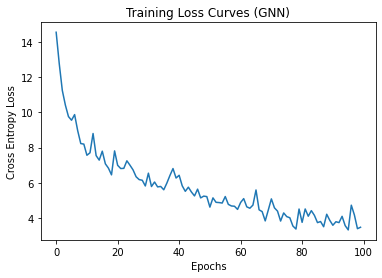

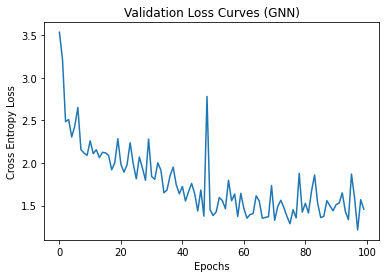

In [73]:
import matplotlib.pyplot as plt
plt.figure()
# plt.plot(np.arange(100),train_loss_original)
plt.plot(np.arange(100),train_loss)

plt.title("Training Loss Curves (GNN)")
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")
plt.savefig("Train Loss Curves GNN.png")


plt.figure()
# plt.plot(np.arange(100),val_loss_original)
plt.plot(np.arange(100),val_loss)
plt.title("Validation Loss Curves (GNN)")
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")
plt.savefig("Validation Loss Curves GNN.png")

